# Design of Experiment
In this notebook, a basic machine learning framework is demonstrated on Banknote Authentication data.

## Import Libraries

In [48]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from IPython.display import Markdown, display

## Import Dataset

In [49]:
# Constants
TARGET = 'class'

df = pd.read_csv('../data/banknote_authentication.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# I. Data Understanding

## Description of Features
| No | Feature | Description |
| --- | --- | --- |
| 1 | variance | Variance of Wavelet Transformed image |
| 2 | skewness | Skewness of Wavelet Transformed image |
| 3 | curtosis | Curtosis of Wavelet Transformed image |
| 4 | entropy | Entropy of image |
| 5 | class | Class (0: forged, 1: genuine) |

## I1. Descriptive Statistics

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


Predictor variables are all of numeric type.

In [51]:
df.shape

(1372, 5)

In [52]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [53]:
df['class'].value_counts()

class
0    762
1    610
Name: count, dtype: int64

## I2. Missing Values and Outliers

### Missing Values

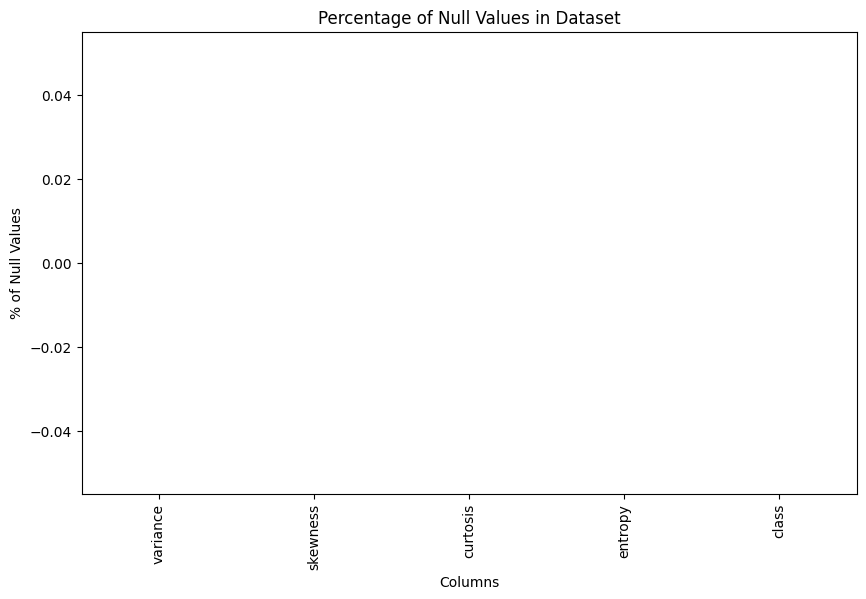

In [54]:
def plot_missing_values(df):
    # Calculate the percentage of null values for each column
    null_perc = df.isnull().sum() / len(df) * 100

    # Create a bar chart
    plt.figure(figsize=(10,6))
    sns.barplot(x=null_perc.index, y=null_perc.values)
    plt.xticks(rotation=90)
    plt.ylabel('% of Null Values')
    plt.xlabel('Columns')
    plt.title('Percentage of Null Values in Dataset')
    plt.show()

plot_missing_values(df)

No missing values in the dataset.

### IQR Method

In [55]:
# Examine interquartile range
def iqr(data, col):
    # Determine IQR for column
    col_values = data[col].values
    q25, q75 = np.percentile(col_values, 25), np.percentile(col_values, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    return ("| `{}` | {} | {} | {} | {} | {} | {} |\n".format(col, str(round(q25,4)), str(round(q75,4)), str(round(iqr,4)), str(round(cut_off,4)), str(round(lower,4)), str(round(upper,4))))

iqr_table = "| Columns | Q25 | Q75 | IQR | Cut Off | Lower Bound | Upper Bound |\n"
iqr_table += "| ------ | --- | --- | --- | ------- | ----------- | ----------- |\n"
for col in df.columns:
    iqr_table += iqr(df, col)

display(Markdown(iqr_table))

| Columns | Q25 | Q75 | IQR | Cut Off | Lower Bound | Upper Bound |
| ------ | --- | --- | --- | ------- | ----------- | ----------- |
| `variance` | -1.773 | 2.8215 | 4.5945 | 6.8917 | -8.6647 | 9.7132 |
| `skewness` | -1.7082 | 6.8146 | 8.5228 | 12.7842 | -14.4924 | 19.5989 |
| `curtosis` | -1.575 | 3.1792 | 4.7542 | 7.1313 | -8.7063 | 10.3106 |
| `entropy` | -2.4134 | 0.3948 | 2.8083 | 4.2124 | -6.6258 | 4.6072 |
| `class` | 0.0 | 1.0 | 1.0 | 1.5 | -1.5 | 2.5 |


In [56]:
# Show outliers
def outliers(data, col):
    # Determine IQR for column
    col_values = data[col].values
    q25, q75 = np.percentile(col_values, 25), np.percentile(col_values, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in col_values if x < lower or x > upper]
    return outliers

outliers_table = "| Columns | Outliers |\n"
outliers_table += "| ------ | --- |\n"
for col in df.columns:
    outliers_table += "| `{}` | {} |\n".format(col, outliers(df, col))

display(Markdown(outliers_table))

| Columns | Outliers |
| ------ | --- |
| `variance` | [] |
| `skewness` | [] |
| `curtosis` | [15.6824, 13.1779, 10.7402, 10.9818, 17.6772, 12.4547, 14.9704, 12.7957, 10.3846, 17.3087, 11.9655, 15.5573, 11.9149, 11.8318, 10.939, 17.9274, 11.3897, 14.3689, 10.4403, 13.0545, 10.5405, 11.388, 16.9583, 12.363, 14.8881, 11.9552, 11.6433, 10.4052, 17.5795, 10.5234, 15.6773, 12.6689, 11.8678, 10.969, 17.6052, 11.4419, 15.6199, 10.3315, 12.9817, 10.5251, 11.244, 17.1116, 12.555, 15.6559, 12.7957, 10.4266, 17.0834, 12.1291, 15.4417, 13.0597, 10.3332, 16.7166, 11.8387, 15.1606, 13.4727, 10.4849, 10.8867, 17.5932, 12.393] |
| `entropy` | [-6.8103, -7.5034, -7.5034, -7.0495, -6.8103, -7.5836, -7.5034, -7.7853, -6.8194, -7.7581, -8.5482, -7.5487, -7.1025, -7.6418, -7.8719, -6.9978, -6.8103, -7.6612, -6.6797, -6.7754, -7.0107, -6.959, -6.8607, -7.5034, -7.5344, -7.3004, -6.7844, -7.5887, -7.5642, -6.9642, -7.5887, -7.3987, -6.8517] |
| `class` | [] |


### Clustering

In [57]:
# Using DBSCAN
from sklearn.cluster import DBSCAN

EPSILON = 1.5
MIN_SAMPLES = 10

# Create DBSCAN object
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)

# Fit model
dbscan.fit(df)

# Get outliers
outliers_df = df[dbscan.labels_ == -1]
outliers_df

# Show outliers
print(f"{round(len(outliers_df)/len(df) * 100, 2)}% of the dataset are outliers based on DBSCAN with epsilon={EPSILON} and min_samples={MIN_SAMPLES}")

4.23% of the dataset are outliers based on DBSCAN with epsilon=1.5 and min_samples=10


### Isolation Forest

In [58]:
# Using Isolation Forest
from sklearn.ensemble import IsolationForest
import warnings

warnings.filterwarnings("ignore", message="X does not have valid feature names, but IsolationForest was fitted with feature names")

# Create Isolation Forest object
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)

# Fit model
isolation_forest.fit(df)

# Get outliers
outliers_df = df[isolation_forest.predict(df) == -1]

# Show outliers
print(f"{round(len(outliers_df)/len(df) * 100, 2)}% of the dataset are outliers based on Isolation Forest with n_estimators={100} and contamination={0.01}")

1.02% of the dataset are outliers based on Isolation Forest with n_estimators=100 and contamination=0.01


## I3. Correlation Analysis and Distribution

### Correlation

In [59]:
def plot_corr_matrix(data, method):
    corr = data.corr(method=method)

    annotations = []
    for i, row in enumerate(corr.index):
        for j, col in enumerate(corr.columns):
            coefficient = f"{corr.iloc[i, j]:.2f}"
            annotations.append(
                {
                    "x": col,
                    "y": row,
                    "text": coefficient,
                    "showarrow": False,
                    "font": {"color": "white" if abs(corr.iloc[i, j]) > 0.5 else "black"},
                }
            )

    fig = go.Figure(
        data=go.Heatmap(
            z=corr,
            x=corr.columns,
            y=corr.index,
            colorscale="Inferno",
            colorbar=dict(title="Correlation"),
        )
    )

    fig.update_layout(
        title_text=f"Correlation Matrix ({method})",
        title_x=0.5,
        annotations=annotations,
    )
    fig.show()

plot_corr_matrix(df, "pearson")


### Distribution

In [60]:
# Plot distribution by class
for feat in df.columns:
    fig = px.histogram(df, x=feat, color='class', marginal='box')
    fig.update_layout(title_text=f'Feature {feat} Distribution by Class', title_x=0.5)
    fig.show()

In [61]:
def hist_box_plot(data):
    # Create a figure with two subplots
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

    # Create a histogram subplot
    sns.histplot(data=data, ax=ax[0], kde=True)
    ax[0].set_xlabel('Values')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title('Histogram')

    # Create a boxplot subplot
    sns.boxplot(data=data, ax=ax[1])
    ax[1].set_xlabel('Values')
    ax[1].set_ylabel('Distribution')
    ax[1].set_title('Boxplot')

    # Display the plot
    plt.show()

def describe_feature(data, feature):
    # Calculate statistics
    median = data[feature].median()
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Create description
    if (feature != 'pH'):
        description = f"### {feature.capitalize()}\n"
    else:
        description = "### pH\n"
    description += f"The distribution of `{feature}` is:\n"

    # Shape
    if data[feature].skew() < -1 or data[feature].skew() > 1:
        description += "- Highly skewed\n"
    elif data[feature].skew() < -0.5 or data[feature].skew() > 0.5:
        description += "- Moderately skewed\n"
    else:
        description += "- Approximately symmetric\n"

    # Central tendency
    description += f"- The median is {median:.2f}\n"

    # Spread
    if data[feature].kurtosis() > 3:
        description += "- Heavy-tailed\n"
    elif data[feature].kurtosis() < 3:
        description += "- Light-tailed\n"
    else:
        description += "- Mesokurtic\n"

    # Boxplot
    description += f"\nThe boxplot of `{feature}` shows:\n"
    description += f"- The median is {median:.2f}\n"
    description += f"- The first quartile is {q1:.2f}\n"
    description += f"- The third quartile is {q3:.2f}\n"
    description += f"- The interquartile range is {iqr:.2f}\n"
    description += f"- Values below {lower:.2f} or above {upper:.2f} are considered outliers\n"

    # Display description
    display(Markdown(description))

    # Display plot
    hist_box_plot(data[feature])

def normality_test(df, col, alpha):
    statistic_value, p_value = scipy.stats.normaltest(df[col])
    message = "After conducting the normality test, we get:\n\n"
    message += f"Statistic Value: {statistic_value}\n\n"
    message += f"P-Value: {p_value}\n\n"
    if(p_value < alpha):
        message += f"With {(1.0 - alpha) * 100}% confidence, we can conclude that the {col} feature is not normally distributed"
    else:
        message += f"With {(1.0 - alpha) * 100}% confidence, we can conclude that the {col} feature is normally distributed"
    display(Markdown(message))

### Variance
The distribution of `variance` is:
- Approximately symmetric
- The median is 0.50
- Light-tailed

The boxplot of `variance` shows:
- The median is 0.50
- The first quartile is -1.77
- The third quartile is 2.82
- The interquartile range is 4.59
- Values below -8.66 or above 9.71 are considered outliers


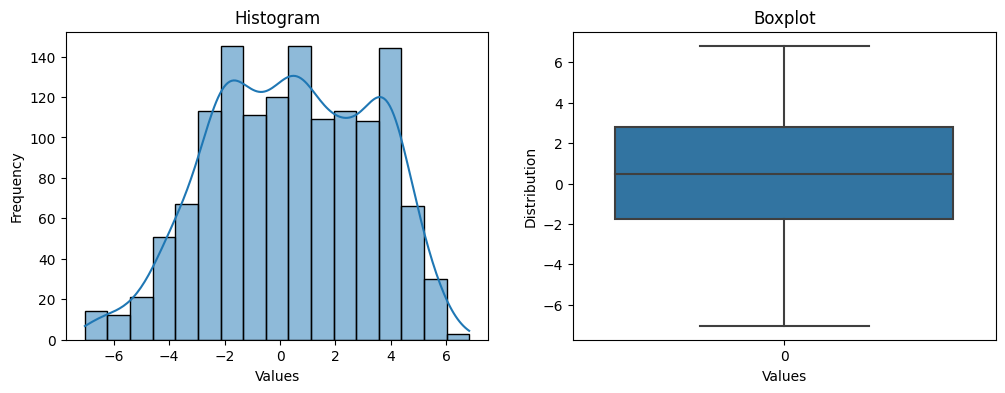

After conducting the normality test, we get:

Statistic Value: 95.53089490739131

P-Value: 1.8018960996631497e-21

With 95.0% confidence, we can conclude that the variance feature is not normally distributed

### Skewness
The distribution of `skewness` is:
- Approximately symmetric
- The median is 2.32
- Light-tailed

The boxplot of `skewness` shows:
- The median is 2.32
- The first quartile is -1.71
- The third quartile is 6.81
- The interquartile range is 8.52
- Values below -14.49 or above 19.60 are considered outliers


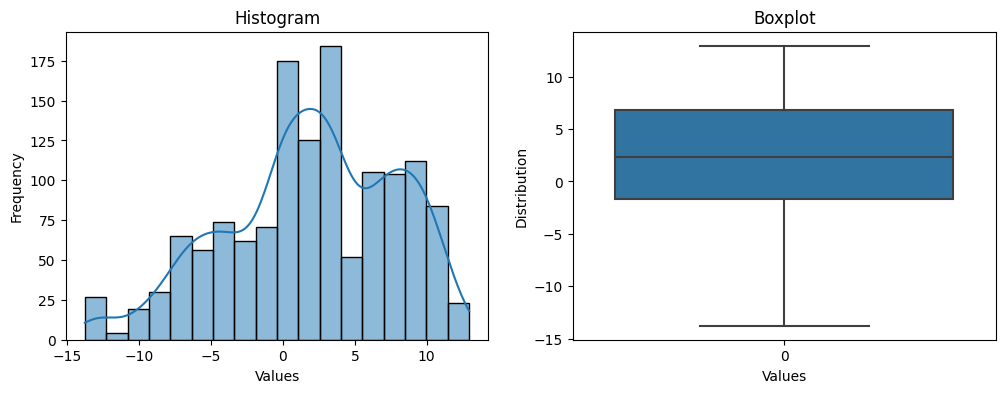

After conducting the normality test, we get:

Statistic Value: 51.26952922828647

P-Value: 7.361446890369984e-12

With 95.0% confidence, we can conclude that the skewness feature is not normally distributed

### Curtosis
The distribution of `curtosis` is:
- Highly skewed
- The median is 0.62
- Light-tailed

The boxplot of `curtosis` shows:
- The median is 0.62
- The first quartile is -1.57
- The third quartile is 3.18
- The interquartile range is 4.75
- Values below -8.71 or above 10.31 are considered outliers


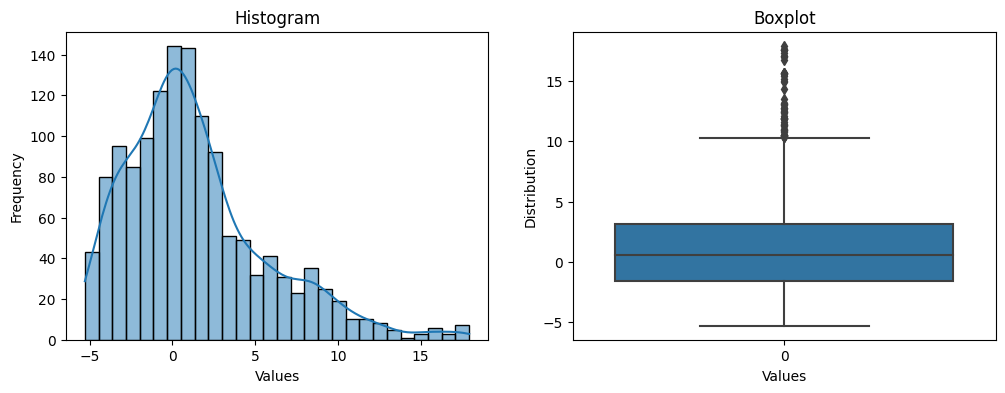

After conducting the normality test, we get:

Statistic Value: 224.92270535295074

P-Value: 1.440970550894426e-49

With 95.0% confidence, we can conclude that the curtosis feature is not normally distributed

### Entropy
The distribution of `entropy` is:
- Highly skewed
- The median is -0.59
- Light-tailed

The boxplot of `entropy` shows:
- The median is -0.59
- The first quartile is -2.41
- The third quartile is 0.39
- The interquartile range is 2.81
- Values below -6.63 or above 4.61 are considered outliers


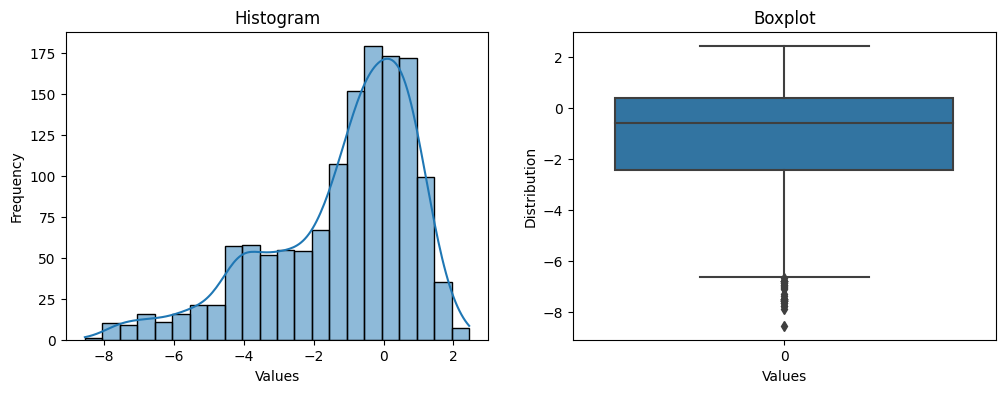

After conducting the normality test, we get:

Statistic Value: 179.75209469429677

P-Value: 9.275313167499287e-40

With 95.0% confidence, we can conclude that the entropy feature is not normally distributed

In [62]:
# Create description for each feature's distribution
for feat in df.columns:
    if feat != TARGET:
        describe_feature(df, feat)
        normality_test(df, feat, 0.05)

## I4. Feature Engineering

### Handle Missing Values
No missing values in the dataset. If there are any, imputation can be done using mean, median, mode, or model-based approach.

### Feature Creation
New features will be derived from existing features.

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, y=None):
        self.y = y # Target variable column
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # New features list
        new_features = ['variance_skewness', 'variance_curv', 'variance_entropy', 'skewness_curv', 'skewness_entropy', 'curv_entropy']

        # Create new features
        X['variance_skewness'] = X['variance'] * X['skewness']
        X['variance_curv'] = X['variance'] * X['curtosis']
        X['variance_entropy'] = X['variance'] * X['entropy']
        X['skewness_curv'] = X['skewness'] * X['curtosis']
        X['skewness_entropy'] = X['skewness'] * X['entropy']
        X['curv_entropy'] = X['curtosis'] * X['entropy']

        # Print the correlation of new features with the target
        for feat in new_features:
            print(f"Feature {feat} has a correlation of {X[feat].corr(self.y):.2f} with the target")
        return X

### Feature Encoding
There are no categorical variables in the dataset, and the target variable `class` is already encoded. If there are any, one-hot encoding or label encoding are most commonly used.

### Feature Scaling
Ideally, feature scaling is done **after** splitting the training and test set. The preprocessing pipeline will be reapplied after the data is split on section III.

In [64]:
# Using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = None
        self.numerical_cols = None
    
    def fit(self, X, y=None):
        self.numerical_cols = X.columns

        self.scaler = MinMaxScaler().fit(X[self.numerical_cols])
        return self
    
    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        
        return X_scaled

### Pipeline
Each of the preprocessing steps above are combined into a pipeline.

In [65]:
from sklearn.pipeline import Pipeline

# Create pipeline
pipeline = Pipeline([
    ('feature_creator', FeatureCreator(y=df[TARGET])),
    ('scaler', FeatureScaler())
])

# Split predictors and target
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# Fit and transform data
X = pipeline.fit_transform(X)

# Show dataframe
X.head()

Feature variance_skewness has a correlation of -0.13 with the target
Feature variance_curv has a correlation of -0.31 with the target
Feature variance_entropy has a correlation of 0.27 with the target
Feature skewness_curv has a correlation of -0.26 with the target
Feature skewness_entropy has a correlation of 0.21 with the target
Feature curv_entropy has a correlation of -0.09 with the target


,variance,skewness,curtosis,entropy,variance_skewness,variance_curv,variance_entropy,skewness_curv,skewness_entropy,curv_entropy
0,0.769004,0.839643,0.106783,0.736628,0.745381,0.685352,0.306328,0.767476,0.673423,0.654353
1,0.835659,0.820982,0.121804,0.644326,0.789615,0.675098,0.240220,0.782123,0.619309,0.679894
2,0.786629,0.416648,0.310608,0.786951,0.425087,0.864159,0.333024,0.833856,0.697521,0.642891
3,0.757105,0.871699,0.054921,0.450440,0.757176,0.647792,0.164251,0.719655,0.469821,0.798035
4,0.531578,0.348662,0.424662,0.687362,0.492349,0.803895,0.323332,0.781131,0.728953,0.591311


# II. Experiments Design

## II1. Metric Selection
Because it is a classification task, accuracy, precision, recall, and F1 score are used as the metrics.
The confusion matrix is also used to visualize the performance of the model.

In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None):

    cm = confusion_matrix(y_true, y_pred)
    
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))

    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

## II2. Split Training and Validation Set

In [67]:
from sklearn.model_selection import train_test_split

# Instantiate new preprocessing pipeline
pipeline = Pipeline([
    ('feature_creator', FeatureCreator(y=df[TARGET])),
    ('scaler', FeatureScaler())
])

# Split data into train and test sets with stratification
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df[TARGET], random_state=42)

# Split predictors and target
X_train = train_set.drop(TARGET, axis=1)
y_train = train_set[TARGET]

X_test = test_set.drop(TARGET, axis=1)
y_test = test_set[TARGET]

# Fit and transform training data
X_train = pipeline.fit_transform(X_train)
print()
X_test = pipeline.transform(X_test)

Feature variance_skewness has a correlation of -0.11 with the target
Feature variance_curv has a correlation of -0.32 with the target
Feature variance_entropy has a correlation of 0.27 with the target
Feature skewness_curv has a correlation of -0.26 with the target
Feature skewness_entropy has a correlation of 0.22 with the target
Feature curv_entropy has a correlation of -0.10 with the target

Feature variance_skewness has a correlation of -0.19 with the target
Feature variance_curv has a correlation of -0.31 with the target
Feature variance_entropy has a correlation of 0.28 with the target
Feature skewness_curv has a correlation of -0.24 with the target
Feature skewness_entropy has a correlation of 0.16 with the target
Feature curv_entropy has a correlation of -0.04 with the target


In [68]:
print(X_train.shape, X_test.shape)

(1097, 10) (275, 10)


## II3. Baseline Model
Logistic Regression model is used as the baseline model. The model is trained on the training set and evaluated on the validation set.

In [69]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Create model
lr = LogisticRegression(random_state=42)

# Fit model
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

In [70]:
# Evaluate logistic regression
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       153
           1       0.95      1.00      0.98       122

    accuracy                           0.98       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.98      0.98      0.98       275



Performance is already very good, with 98% accuracy, precision, recall, and F1-score.

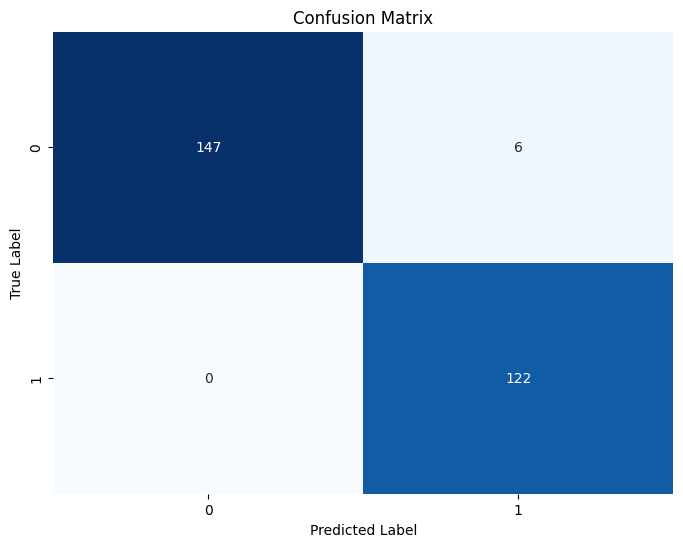

In [71]:
plot_confusion_matrix(y_test, y_pred, )

## II4. Model Selection and Hyperparameter Tuning
Try out other models and tune the hyperparameters to improve the performance.

### SVC

In [72]:
from sklearn.svm import SVC

# Create model
svc = SVC(random_state=42)

# Fit model
svc.fit(X_train, y_train)

# Predict
y_pred = svc.predict(X_test)

# Evaluate SVC
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



### Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

# Create model
rf = RandomForestClassifier(random_state=42)

# Fit model
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate random forest
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



### XGBoost

In [74]:
from xgboost import XGBClassifier

# Create model
xgb = XGBClassifier(random_state=42)

# Fit model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluate XGBClassifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



### Grid Search Hyperparameter Tuning
There's really not much else to do, the model performance is already very good.  
We will try it regardless.

In [75]:
from sklearn.model_selection import GridSearchCV

# Create parameter grid for XGBClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create grid search object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters
grid_search.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

In [76]:
# Evaluate XGBClassifier with best parameters
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



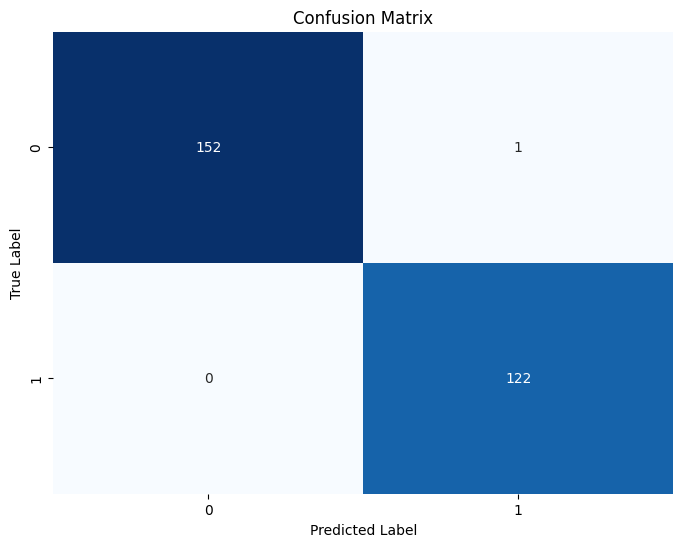

In [77]:
plot_confusion_matrix(y_test, y_pred)

### Cross Validation
Using 5-fold cross validation to evaluate the consistency of the model.

In [78]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(random_state=42)
svc = SVC(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, **grid_search.best_params_) # Tuned XGBClassifier

models = [lr, svc, rf, xgb]

for model in models:
    print(f"Model: {model.__class__.__name__}")
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")
    print()

Model: LogisticRegression
Scores: [0.99090909 0.97727273 0.98173516 0.97716895 0.96803653]
Mean: 0.9790244914902448
Standard Deviation: 0.007427495456807284

Model: SVC
Scores: [1.         0.99090909 0.98630137 1.         0.99086758]
Mean: 0.993615608136156
Standard Deviation: 0.005475324558379406

Model: RandomForestClassifier
Scores: [0.99545455 0.99545455 0.99543379 0.99543379 1.        ]
Mean: 0.9963553341635534
Standard Deviation: 0.0018223565575918863

Model: XGBClassifier
Scores: [1.         0.99545455 1.         0.99086758 0.99543379]
Mean: 0.9963511830635119
Standard Deviation: 0.0034159391900414823



Random Forest performs the best and is the most consistent.

# III. Improvements

## III1. Resampling

In [79]:
# Initial distribution for training set
y_train.value_counts()

class
0    609
1    488
Name: count, dtype: int64

### Oversampling

In [80]:
# Oversampling with SMOTE
from imblearn.over_sampling import SMOTE

# Create SMOTE object
smote = SMOTE(random_state=42)

# Fit and transform training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Show class distribution
y_train_smote.value_counts()

class
1    609
0    609
Name: count, dtype: int64

In [81]:
# Train XGBClassifier with SMOTE
xgb = XGBClassifier(random_state=42, **grid_search.best_params_)

# Fit model
xgb.fit(X_train_smote, y_train_smote)

# Predict
y_pred = xgb.predict(X_test)

# Evaluate XGBClassifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



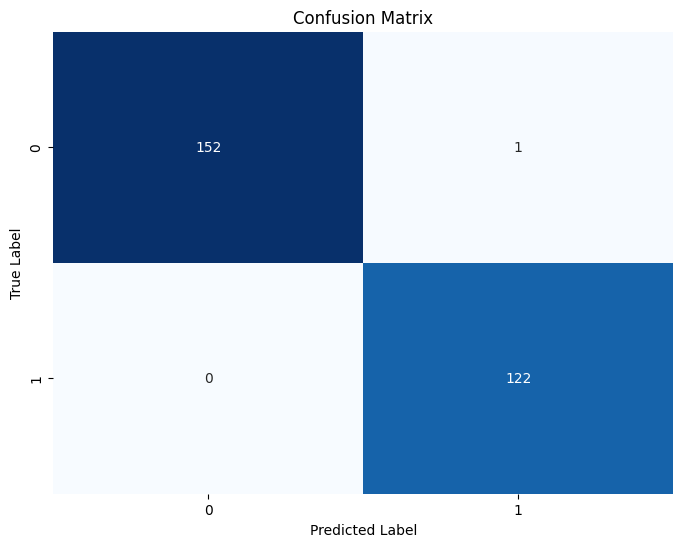

In [82]:
plot_confusion_matrix(y_test, y_pred)

### Undersampling

In [83]:
# Using random undersampling
from imblearn.under_sampling import RandomUnderSampler

# Create RandomUnderSampler object
rus = RandomUnderSampler(random_state=42)

# Fit and transform training data
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Show class distribution
y_train_rus.value_counts()

class
0    488
1    488
Name: count, dtype: int64

In [84]:
# Train XGBClassifier with SMOTE
xgb = XGBClassifier(random_state=42, **grid_search.best_params_)

# Fit model
xgb.fit(X_train_rus, y_train_rus)

# Predict
y_pred = xgb.predict(X_test)

# Evaluate XGBClassifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



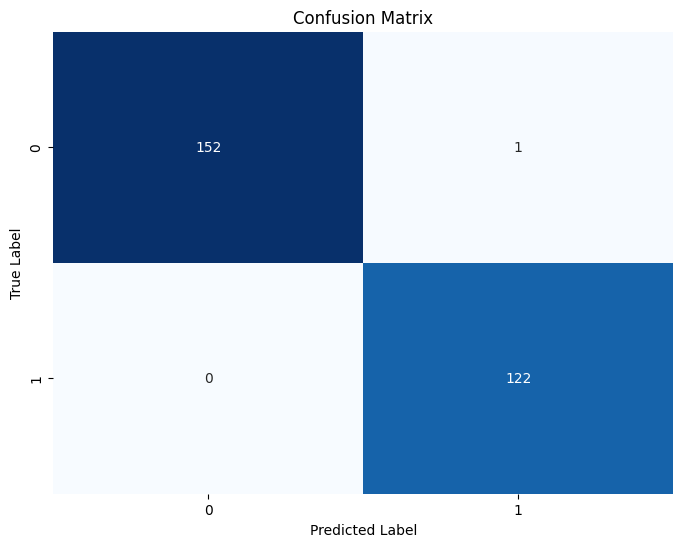

In [85]:
plot_confusion_matrix(y_test, y_pred)

## III2. Ensemble Methods

### Stacking

In [86]:
# Use stacking
from sklearn.ensemble import StackingClassifier

# Create estimators
estimators = [
    ('lr', LogisticRegression(random_state=42)),
    ('svc', SVC(random_state=42))
]

# Create stacking classifier
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42), cv=5)

# Fit model
stacking.fit(X_train, y_train)

# Predict
y_pred = stacking.predict(X_test)

# Evaluate stacking classifier
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



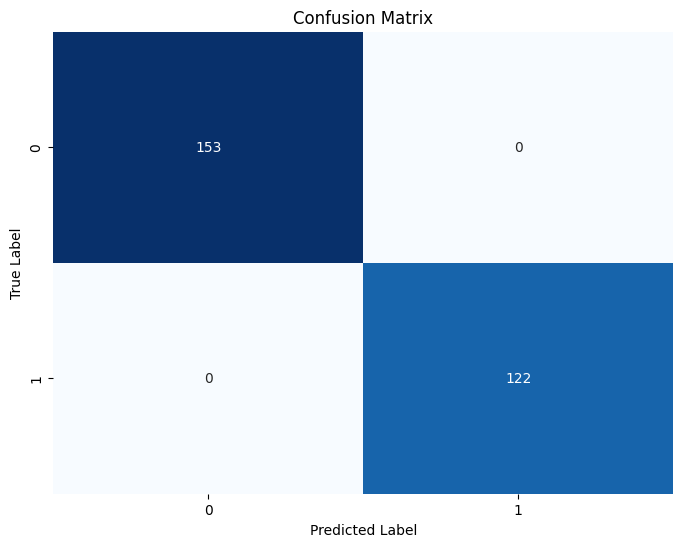

In [87]:
plot_confusion_matrix(y_test, y_pred)

### Voting

In [88]:
# Soft voting
from sklearn.ensemble import VotingClassifier

# Create estimators
estimators = [
    ('lr', LogisticRegression(random_state=42)),
    ('svc', SVC(random_state=42, probability=True)),
]

# Create voting classifier
soft_voting = VotingClassifier(estimators=estimators, voting='soft')

# Fit model
soft_voting.fit(X_train, y_train)

# Predict
y_pred = soft_voting.predict(X_test)

# Evaluate voting classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



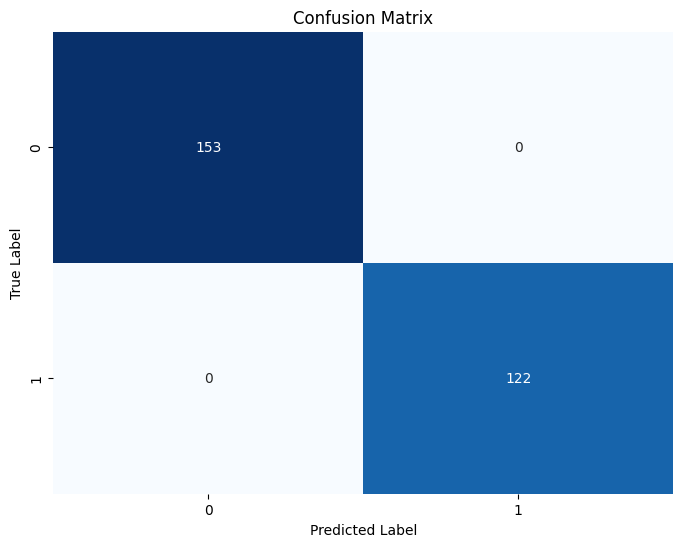

In [89]:
plot_confusion_matrix(y_test, y_pred)

In [90]:
# Hard voting
hard_voting = VotingClassifier(estimators=estimators, voting='hard')

# Fit model
hard_voting.fit(X_train, y_train)

# Predict
y_pred = hard_voting.predict(X_test)

# Evaluate voting classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



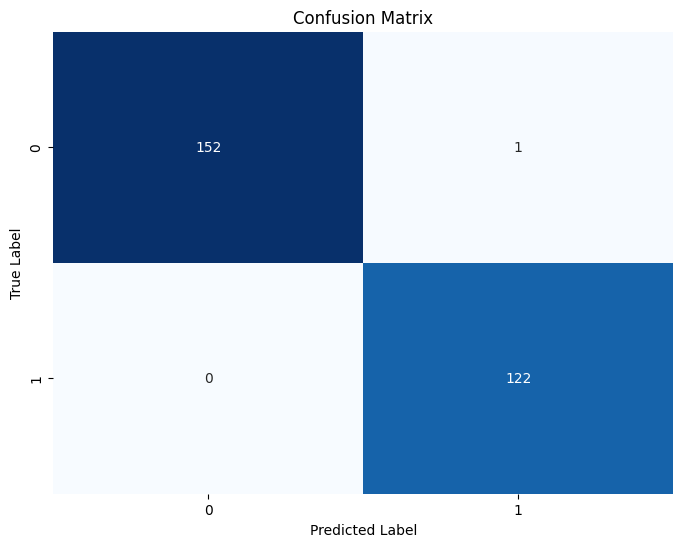

In [91]:
plot_confusion_matrix(y_test, y_pred)

# Analysis

- The dataset is very clean. There are no missing values, no categorical features, and minimal outliers.
- Baseline model of Logistic Regression already performs very well, with 98% accuracy, precision, recall, and F1-score.
- Other models perform similarly, with Tree-Based algorithms performing slightly better on cross validation (Random Forest and XGBoost).
- The base estimators are already very good, there's not much else to do to improve the performance.
- Resampling the data did not improve the performance of the model, as the base estimators are already very good. Realistically, on most real world data, resampling usually helps to make the model more generalized and unbiased, hence improving the performance. Other methods such as class weighting or data augmentation can also be used to achieve similar effects.
- Ensemble method such as stacking and soft voting did improve the performance to have a perfect score of 100% accuracy, precision, recall, and F1-score on the validation set. However, having perfect scores on validation sets is usually a sign of overfitting. This is not the case here, as we know how well the base models already perform on cross validation. The ensemble methods are able to combine the strengths of the base estimators to achieve better performance.
- Hard voting, on the other hand, did not improve the performance of the model. Other than the fact that the base estimators are already very good, hard voting is less preferred than soft voting because it does not take into account the confidence of the predictions.